# Eskuaren detekzioa egiteko programa

Programa honek, Google enpresak eginiko modelo ireki bat erabiltzen du eskuen detekzioa eta posizioak esaten dituena. 

## Erabiliko ditugun liburutegia guztiak txertatu

Zati honetan egin beharrik ez dago, hori bakoitzaren araberakoa da, baina normalean programa bat jarraia bada guztia batera egiten da hasieran.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import to_categorical 
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from os.path import exists
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Beren modeloa ikusi eta ulertu aldagaiak

Aldagaiak ulertzea ezinbestekoa da berarekin zerbait egiten hasteko, beraz atal honetan horretan zentratuko gara.

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:   
        for hand_landmarks in results.multi_hand_landmarks: 
            mp_drawing.draw_landmarks(
                image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    k = cv2.waitKey(1)
    if  k%256 == 27 or k == ord('q'):
      break
cap.release()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Datuak sortu eta csv bezala gordetzeko programa

Lehen ikusitako modeloak sortzen dituen datuak erabiliko ditugu modeloak ikasi dezan 

In [37]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


# Gordeko ditugun puntuen koordenaden izenak
column_names = ['0_x', '0_y', '0_z', '1_x', '1_y', '1_z', '2_x', '2_y', '2_z', '3_x', '3_y', '3_z', '4_x', '4_y', '4_z', 
                '5_x', '5_y', '5_z', '6_x', '6_y', '6_z', '7_x', '7_y', '7_z', '8_x', '8_y', '8_z', '9_x', '9_y', '9_z', 
                '10_x', '10_y', '10_z', '11_x', '11_y', '11_z', '12_x', '12_y', '12_z', '13_x', '13_y', '13_z', '14_x', 
                '14_y', '14_z', '15_x', '15_y', '15_z', '16_x', '16_y', '16_z', '17_x', '17_y', '17_z', '18_x', '18_y', 
                '18_z', '19_x', '19_y', '19_z', '20_x', '20_y', '20_z', 'classes']

if exists('datos.csv'):
  data = pd.read_csv('datos.csv')
  landmark_csv = pd.DataFrame(data, columns= column_names)
  
else:
  landmark_csv = pd.DataFrame(columns=column_names)


# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    landmark_csv = pd.DataFrame(columns=column_names)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
          key = cv2.waitKey(1)
          if key!=-1:
            points = []
            for n in enumerate(hand_landmarks.landmark):
              points.append(n[1].x)
              points.append(n[1].y)
              points.append(n[1].z)
                
            points.append(chr(key))
            a_series = pd. Series(points, index = column_names)
            landmark_csv = landmark_csv.append(a_series, ignore_index=True)
            
              
          mp_drawing.draw_landmarks(
              image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS,
              mp_drawing_styles.get_default_hand_landmarks_style(),
              mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    k = cv2.waitKey(1)
    if  k%256 == 27 or k == ord('q'):
      break
landmark_csv['classes']= pd.to_numeric(landmark_csv['classes'], errors='coerce').astype('int')
landmark_csv = landmark_csv.dropna()
display(landmark_csv)
landmark_csv.to_csv('datos.csv')
cap.release()


,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,classes
0,0.134657,0.706031,9.072567e-09,0.211390,0.706682,-0.031649,0.286082,0.668941,-0.050598,0.340458,...,0.128413,0.405331,-0.053028,0.124075,0.354581,-0.065166,0.122100,0.306451,-0.075132,1
1,0.191683,0.687444,1.105178e-08,0.263407,0.681651,-0.034724,0.333978,0.642448,-0.057625,0.387802,...,0.161817,0.400503,-0.065021,0.150006,0.351224,-0.077530,0.140942,0.303773,-0.087916,1
2,0.201746,0.692130,1.046971e-08,0.274974,0.683077,-0.036458,0.346051,0.639293,-0.059450,0.398709,...,0.165509,0.402481,-0.059800,0.153408,0.354429,-0.071894,0.144281,0.307997,-0.081957,1
3,0.216800,0.697454,1.009626e-08,0.289905,0.686286,-0.038151,0.359698,0.640132,-0.061724,0.410558,...,0.174265,0.407746,-0.063899,0.163001,0.360220,-0.077572,0.155186,0.314325,-0.088727,1
4,0.229047,0.703675,9.682712e-09,0.300720,0.693605,-0.037595,0.367719,0.647800,-0.061502,0.416434,...,0.186349,0.415254,-0.067700,0.173805,0.368238,-0.082578,0.164900,0.322111,-0.094814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,0.643126,0.520160,4.498404e-09,0.671689,0.457937,0.016565,0.720950,0.399172,0.013187,0.753830,...,0.783634,0.570253,-0.034124,0.761040,0.574288,-0.018493,0.740515,0.559758,-0.010035,4
1301,0.637179,0.521018,4.453662e-09,0.664615,0.458015,0.016087,0.713403,0.398384,0.012427,0.746187,...,0.776232,0.575392,-0.035857,0.753755,0.578795,-0.020681,0.733222,0.563668,-0.012428,4
1302,0.630155,0.523378,4.523752e-09,0.655460,0.460459,0.016059,0.702056,0.399952,0.009776,0.732854,...,0.770722,0.573896,-0.049966,0.748029,0.577089,-0.033175,0.726174,0.561618,-0.022557,4
1303,0.618036,0.523407,5.651243e-09,0.642885,0.463195,0.021995,0.687032,0.400745,0.014334,0.713591,...,0.763831,0.566132,-0.067513,0.745390,0.572231,-0.045395,0.723148,0.558927,-0.029283,4


## Modeloa sortu

Behin datuak gordeta ditugula eta erabilgarri daudela, modeloa sortuko dugu.

In [2]:
column_names = ['0_x', '0_y', '0_z', '1_x', '1_y', '1_z', '2_x', '2_y', '2_z', '3_x', '3_y', '3_z', '4_x', '4_y', '4_z', 
                '5_x', '5_y', '5_z', '6_x', '6_y', '6_z', '7_x', '7_y', '7_z', '8_x', '8_y', '8_z', '9_x', '9_y', '9_z', 
                '10_x', '10_y', '10_z', '11_x', '11_y', '11_z', '12_x', '12_y', '12_z', '13_x', '13_y', '13_z', '14_x', 
                '14_y', '14_z', '15_x', '15_y', '15_z', '16_x', '16_y', '16_z', '17_x', '17_y', '17_z', '18_x', '18_y', 
                '18_z', '19_x', '19_y', '19_z', '20_x', '20_y', '20_z', 'classes']
if exists('datos.csv'):
  data = pd.read_csv('datos.csv')
  landmark_csv = pd.DataFrame(data, columns= column_names)

else:
  print('Ez da horrelako dokumenturik bilatu')

In [3]:
model= keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[landmark_csv.shape[1]-1]))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(len(pd.unique(landmark_csv['classes']))+1, activation="softmax"))

2022-02-01 13:56:15.242324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 13:56:15.243467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 13:56:15.244067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.785GHz coreCount: 82 deviceMemorySize: 23.67GiB deviceMemoryBandwidth: 871.81GiB/s
2022-02-01 13:56:15.244150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 63)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16384     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 33,157
Trainable params: 33,157
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.layers

In [6]:
hidden1=model.layers[1]
hidden1.name

'dense'

In [7]:
model.get_layer('dense_2') is hidden1

False

In [8]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.04252769, -0.1267502 , -0.13518463, ..., -0.06741792,
         0.01505406,  0.05587761],
       [-0.08329153, -0.06458429,  0.12947193, ..., -0.10593371,
         0.08365664, -0.03016572],
       [ 0.00520806,  0.10476731, -0.00055985, ..., -0.00739922,
        -0.00633277,  0.00445716],
       ...,
       [-0.11611523,  0.01720847,  0.10682938, ...,  0.04304127,
        -0.10637222,  0.12774119],
       [ 0.05167224, -0.04583666,  0.01625359, ..., -0.12721388,
        -0.06032306,  0.00961348],
       [ 0.01641473, -0.04809975, -0.02318222, ..., -0.01880553,
         0.1313495 ,  0.05306922]], dtype=float32)

In [9]:
weights.shape

(63, 256)

In [10]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [11]:
biases.shape

(256,)

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer= "Adam",
              metrics =["accuracy"])

## Modeloa entrenatu

In [13]:
from sklearn.model_selection import train_test_split

column_names = ['0_x', '0_y', '0_z', '1_x', '1_y', '1_z', '2_x', '2_y', '2_z', '3_x', '3_y', '3_z', '4_x', '4_y', '4_z', 
                '5_x', '5_y', '5_z', '6_x', '6_y', '6_z', '7_x', '7_y', '7_z', '8_x', '8_y', '8_z', '9_x', '9_y', '9_z', 
                '10_x', '10_y', '10_z', '11_x', '11_y', '11_z', '12_x', '12_y', '12_z', '13_x', '13_y', '13_z', '14_x', 
                '14_y', '14_z', '15_x', '15_y', '15_z', '16_x', '16_y', '16_z', '17_x', '17_y', '17_z', '18_x', '18_y', 
                '18_z', '19_x', '19_y', '19_z', '20_x', '20_y', '20_z', 'classes']
                
if exists('datos.csv'):
  data = pd.read_csv('datos.csv')
  landmark_csv = pd.DataFrame(data, columns= column_names)
  y = to_categorical(landmark_csv['classes'])
  x = landmark_csv.drop('classes',axis=1)
  print(x.shape)
  print(y.shape)
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

else:
  print('Ez da horrelako dokumenturik bilatu')



(1305, 63)
(1305, 5)


In [14]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))


2022-02-01 13:56:21.467037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-01 13:56:21.487810: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3999960000 Hz


Epoch 1/30


2022-02-01 13:56:21.686833: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


33/33 [==============================] - 1s 4ms/step - loss: 1.2602 - accuracy: 0.4741 - val_loss: 1.0285 - val_accuracy: 0.7356
Epoch 2/30
33/33 [==============================] - 0s 2ms/step - loss: 0.8941 - accuracy: 0.7337 - val_loss: 0.6976 - val_accuracy: 0.8352
Epoch 3/30
 1/33 [..............................] - ETA: 0s - loss: 0.7165 - accuracy: 0.8125

2022-02-01 13:56:22.203118: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-01 13:56:22.203166: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


33/33 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.8946 - val_loss: 0.4735 - val_accuracy: 0.9732
Epoch 4/30
33/33 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.9550 - val_loss: 0.3192 - val_accuracy: 0.9847
Epoch 5/30
33/33 [==============================] - 0s 2ms/step - loss: 0.2669 - accuracy: 0.9799 - val_loss: 0.2085 - val_accuracy: 1.0000
Epoch 6/30
33/33 [==============================] - 0s 2ms/step - loss: 0.1828 - accuracy: 0.9895 - val_loss: 0.1468 - val_accuracy: 1.0000
Epoch 7/30
33/33 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 0.9923 - val_loss: 0.1018 - val_accuracy: 0.9962
Epoch 8/30
33/33 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9981 - val_loss: 0.0703 - val_accuracy: 1.0000
Epoch 9/30
33/33 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 1.0000
Epoch 10/30
33/33 [============

In [15]:
model.save('posizio_klasifikatzailea_0.h5')

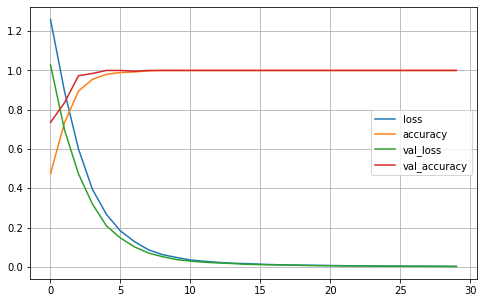

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

In [17]:
model.evaluate(x_val,y_val)

9/9 [==============================] - 0s 920us/step - loss: 0.0020 - accuracy: 1.0000


[0.002006339142099023, 1.0]

## Martxan jarri predikzioak egiten

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

new_model = keras.models.load_model('posizio_klasifikatzailea_0.h5')

column_names = ['0_x', '0_y', '0_z', '1_x', '1_y', '1_z', '2_x', '2_y', '2_z', '3_x', '3_y', '3_z', '4_x', '4_y', '4_z', 
                '5_x', '5_y', '5_z', '6_x', '6_y', '6_z', '7_x', '7_y', '7_z', '8_x', '8_y', '8_z', '9_x', '9_y', '9_z', 
                '10_x', '10_y', '10_z', '11_x', '11_y', '11_z', '12_x', '12_y', '12_z', '13_x', '13_y', '13_z', '14_x', 
                '14_y', '14_z', '15_x', '15_y', '15_z', '16_x', '16_y', '16_z', '17_x', '17_y', '17_z', '18_x', '18_y', 
                '18_z', '19_x', '19_y', '19_z', '20_x', '20_y', '20_z']

hand_mesh_names = {0: 'Eskurik gabe', 1:'Zabalik', 2:'Hatza igota', 3:'Heavy', 4:'Hatz potola'}

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    landmark_csv = pd.DataFrame(columns=column_names)
    hand_landmark_result=0
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      landmark_csv = pd.DataFrame(columns=column_names)
      for hand_landmarks in results.multi_hand_landmarks:
        
        points = []
        for n in enumerate(hand_landmarks.landmark):
          points.append(n[1].x)
          points.append(n[1].y)
          points.append(n[1].z)
        if len(points)==63:
          a_series = pd. Series(points, index = column_names)
          landmark_csv = landmark_csv.append(a_series, ignore_index=True)
          hand_landmark_result = int(np.argmax(new_model.predict(landmark_csv)))
            
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    image =cv2.flip(image, 1)
    cv2.putText(img=image, text=str(hand_mesh_names[hand_landmark_result]), org=(10, 50), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 0, 0),thickness=2)
    cv2.imshow('MediaPipe Hands', image)
    k = cv2.waitKey(1)
    if  k%256 == 27 or k == ord('q'):
      break

cap.release()

## Martxan jarri predikzioak egiten eta ardatzak hartzen

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

new_model = keras.models.load_model('posizio_klasifikatzailea_0.h5')

column_names = ['0_x', '0_y', '0_z', '1_x', '1_y', '1_z', '2_x', '2_y', '2_z', '3_x', '3_y', '3_z', '4_x', '4_y', '4_z', 
                '5_x', '5_y', '5_z', '6_x', '6_y', '6_z', '7_x', '7_y', '7_z', '8_x', '8_y', '8_z', '9_x', '9_y', '9_z', 
                '10_x', '10_y', '10_z', '11_x', '11_y', '11_z', '12_x', '12_y', '12_z', '13_x', '13_y', '13_z', '14_x', 
                '14_y', '14_z', '15_x', '15_y', '15_z', '16_x', '16_y', '16_z', '17_x', '17_y', '17_z', '18_x', '18_y', 
                '18_z', '19_x', '19_y', '19_z', '20_x', '20_y', '20_z']

hand_mesh_names = {0: 'Eskurik gabe', 1:'Zabalik', 2:'Hatza igota', 3:'Heavy', 4:'Hatz potola'}

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    landmark_csv = pd.DataFrame(columns=column_names)
    hand_landmark_result=0
    x_ardatza, y_ardatza, z_ardatza = 0, 0, 0
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      landmark_csv = pd.DataFrame(columns=column_names)
      for hand_landmarks in results.multi_hand_landmarks:
        
        points = []
        for n in enumerate(hand_landmarks.landmark):
          points.append(n[1].x)
          points.append(n[1].y)
          points.append(n[1].z)
        if len(points)==63:
          a_series = pd. Series(points, index = column_names)
          landmark_csv = landmark_csv.append(a_series, ignore_index=True)
          hand_landmark_result = int(np.argmax(new_model.predict(landmark_csv)))

          if hand_landmark_result == 2:
            x_hatz, y_hatz, z_hatz = points[8*3],points[8*3+1],points[8*3+2]
            x_ardatza, y_ardatza, z_ardatza = round(points[8*3],2),round(points[8*3+1],2),round(points[8*3+2],2)
            
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    image =cv2.flip(image, 1)
    cv2.putText(img=image, text=str(hand_mesh_names[hand_landmark_result]), org=(10, 50), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 0, 0),thickness=2)
    if hand_mesh_names[hand_landmark_result] == 'Hatza igota':
      cv2.putText(img=image, text= str(' x:' + str(1-x_ardatza) + ' y:' + str(1-y_ardatza) + ' z:' + str(-z_ardatza)), org=(10, 100), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=1)
    cv2.imshow('MediaPipe Hands', image)
    k = cv2.waitKey(1)
    if  k%256 == 27 or k == ord('q'):
      break

cap.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
